# Titanic - Machine Learning from Disaster

The notebook walks us through the workflow for using machine learning to create a best model that predicts which passengers survived the Titanic shipwreck. This corresponds to my 8th and last project in my Engineer Machine Learning path with OpenClassroom.

# Importing the Libraries

In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import warnings

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer

from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import GridSearchCV, cross_val_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) 
# that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, 
# but they won't be saved outside of the current session

# Ignore pandas warnings
warnings.filterwarnings('ignore')

# !pip install flake8 pycodestyle_magic
%load_ext pycodestyle_magic
%pycodestyle_on

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Getting the Data

In [35]:
# load data
train_data = pd.read_csv(r"/kaggle/input/titanic/train.csv")
test_data = pd.read_csv(r"/kaggle/input/titanic/test.csv")

Let's make a copy of the two datasets

In [36]:
train_set = train_data.copy()
test_set = test_data.copy()

We are splitting the training dataset into two parts for the validation set. 75% of the data would be used for training and 25% for the validation.

In [37]:
train = train_set.sample(frac=0.75, random_state=0)
val = train_set.drop(train.index)

In [38]:
# Creating a copy of our datasets
trainData = train.copy()
valData = val.copy()
testData = test_set.copy()

In [39]:
# Let put the PassengerId variable apart for the testing.
test_PassengerID = testData['PassengerId']

**How many Passengers do we have in total**

In [40]:
TotalPassengers = len(trainData) + len(valData) + len(testData)
TotalPassengers

1309

# Descriptive analysis training dataset

In [41]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


**which features are available in the dataset?**

In [42]:
train.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

Noting the feature names for directly manipulating or analyzing these. These feature names are described on the [Kaggle data page here!](https://www.kaggle.com/c/titanic/data).

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 495 to 539
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  668 non-null    int64  
 1   Survived     668 non-null    int64  
 2   Pclass       668 non-null    int64  
 3   Name         668 non-null    object 
 4   Sex          668 non-null    object 
 5   Age          538 non-null    float64
 6   SibSp        668 non-null    int64  
 7   Parch        668 non-null    int64  
 8   Ticket       668 non-null    object 
 9   Fare         668 non-null    float64
 10  Cabin        151 non-null    object 
 11  Embarked     667 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 67.8+ KB


The training dataset has 668 entries with 12 variables. Within these variables, 7 are numerics(integer or floats) and 5 are strings(object). 

* **Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

<ul>
    <li>Categorical</li>
        <ul>
            <li>Survived</li>
            <li>Sex</li>
            <li>Embarked</li>
        </ul>
    <li>ordinal</li>
        <ul>
            <li>Pclass</li>
        </ul>
</ul>

**Which features are numerical?**

These values change from sample to sample. Within numerical features are the values `discrete`, `continuous`, or `timeseries based`? Among other things this helps us select the appropriate plots for visualization.

<ul>
    <li>Continous</li>
        <ul>
            <li>Age</li>
            <li>Fare</li>
        </ul>
    <li>Discrete</li>
        <ul>
            <li>SibSp</li>
            <li>Parch</li>
        </ul>
</ul>

**Which features are alphanumeric data types?**

These are candidates for correcting goal.

<li>Ticket is a mix of numeric and alphanumeric data types.</li> 
<li>Cabin is alphanumeric.</li> 

**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

<li>Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.</li>

In [44]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
Cabin,517,77.4
Age,130,19.5
Embarked,1,0.1
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
SibSp,0,0.0
Parch,0,0.0


<AxesSubplot:>

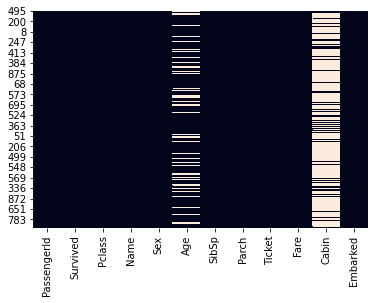

In [45]:
sns.heatmap(train.isnull(), cbar=False)

**Which features contain blank, null or empty values?**

These will require correcting.

<li>Cabin</li>
<li>Age</li>
<li>Embarked</li>

## Univariate Analysis

### Survived variable

In [46]:
# grouping data by Survival type
data = train.groupby("Survived")["PassengerId"].count()
data

Survived
0    419
1    249
Name: PassengerId, dtype: int64

Text(0.5, 1.0, 'Survived Passengers')

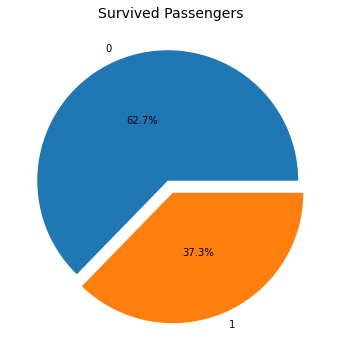

In [47]:
pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data,
        autopct="%.1f%%",
        explode=[0.05]*2,
        labels=labels,
        pctdistance=0.5)
plt.title("Survived Passengers", fontsize=14)

### Pclass variable

In [48]:
# grouping data by Survival type
data = train.groupby("Pclass")["PassengerId"].count()
data

Pclass
1    160
2    136
3    372
Name: PassengerId, dtype: int64

Text(0.5, 1.0, 'Pclass analysis')

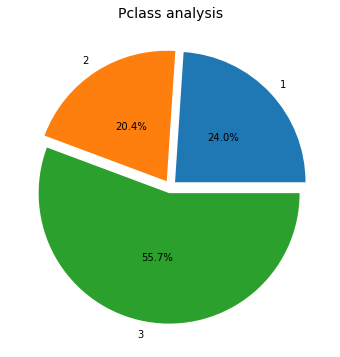

In [49]:
pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data,
        autopct="%.1f%%",
        explode=[0.05]*3,
        labels=labels,
        pctdistance=0.5)
plt.title("Pclass analysis", fontsize=14)

### Sex variable

In [50]:
# grouping data by Survival type
data = train.groupby("Sex")["PassengerId"].count()
data

Sex
female    238
male      430
Name: PassengerId, dtype: int64

Text(0.5, 1.0, 'Gender analysis')

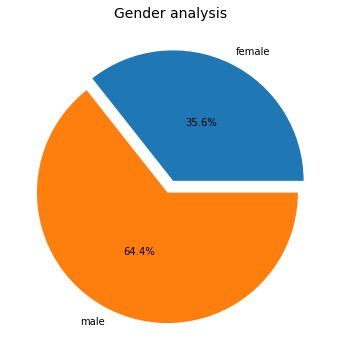

In [51]:
pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data,
        autopct="%.1f%%",
        explode=[0.05]*2,
        labels=labels,
        pctdistance=0.5)
plt.title("Gender analysis", fontsize=14)

### SibSp variable

In [52]:
# grouping data by Survival type
data = train.groupby("SibSp")["PassengerId"].count()
data

SibSp
0    461
1    147
2     21
3     15
4     15
5      5
8      4
Name: PassengerId, dtype: int64

Text(0.5, 1.0, 'SibSp analysis')

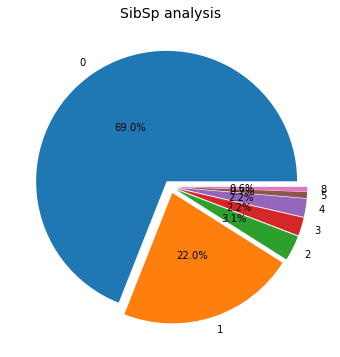

In [53]:
pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data,
        autopct="%.1f%%",
        explode=[0.05]*7,
        labels=labels,
        pctdistance=0.5)
plt.title("SibSp analysis", fontsize=14)

### Parch variable 

In [54]:
# grouping data by Survival type
data = train.groupby("Parch")["PassengerId"].count()
data

Parch
0    511
1     91
2     58
3      1
4      3
5      3
6      1
Name: PassengerId, dtype: int64

Text(0.5, 1.0, 'Parch analysis')

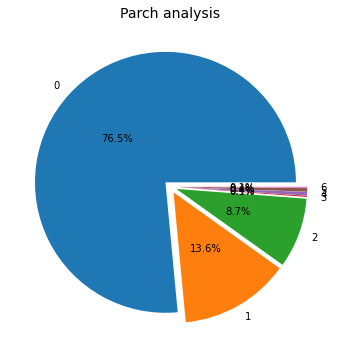

In [55]:
pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data,
        autopct="%.1f%%",
        explode=[0.05]*7,
        labels=labels,
        pctdistance=0.5)
plt.title("Parch analysis", fontsize=14)

### Embarked variable

In [56]:
# grouping data by Survival type
data = train.groupby("Embarked")["PassengerId"].count()
data

Embarked
C    122
Q     56
S    489
Name: PassengerId, dtype: int64

Text(0.5, 1.0, 'Embarked analysis')

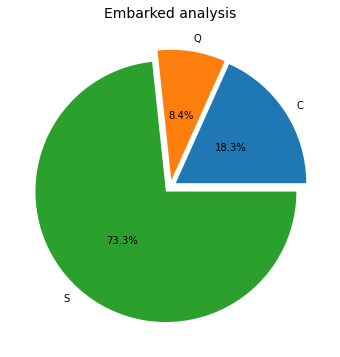

In [57]:
pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data,
        autopct="%.1f%%",
        explode=[0.05]*3,
        labels=labels,
        pctdistance=0.5)
plt.title("Embarked analysis", fontsize=14)

### Age variable

In [58]:
train.Age.describe()

count    538.000000
mean      29.321245
std       14.400203
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Density'>

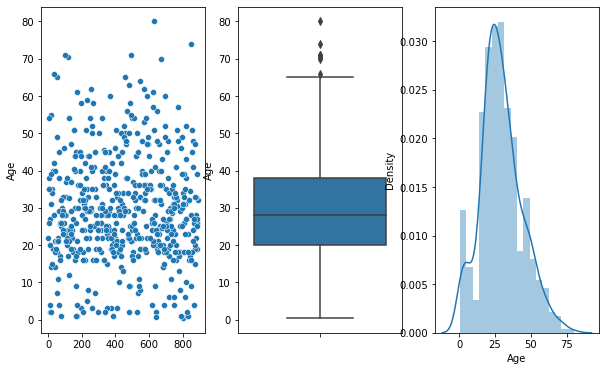

In [59]:
fig, axs = plt.subplots(figsize=[10, 6], ncols=3)
sns.scatterplot(data=train["Age"], ax=axs[0])
sns.boxplot(y=train["Age"], ax=axs[1])
sns.distplot(train["Age"], ax=axs[2])

<AxesSubplot:ylabel='Density'>

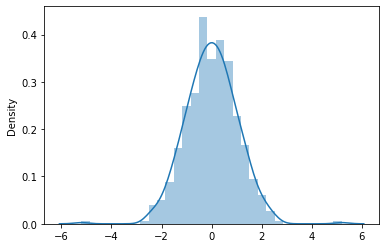

In [60]:
qt = QuantileTransformer(n_quantiles=100,
                         output_distribution='normal',
                         random_state=0)
qt_transf = qt.fit_transform(train["Age"].values.reshape(-1,1))
sns.distplot(qt_transf)

### Fare variable

In [61]:
train.Fare.describe()

count    668.000000
mean      32.498060
std       52.925476
min        0.000000
25%        7.925000
50%       14.454200
75%       30.500000
max      512.329200
Name: Fare, dtype: float64

In [62]:
train.Fare.quantile([.80, .85, .90, .95])

0.80     39.6525
0.85     54.9050
0.90     76.7292
0.95    113.2750
Name: Fare, dtype: float64

<AxesSubplot:xlabel='Fare', ylabel='Density'>

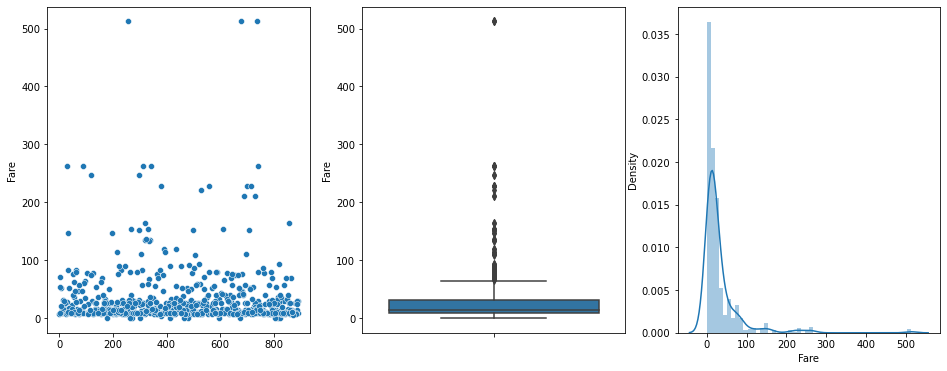

In [63]:
fig, axs = plt.subplots(figsize=[16, 6], ncols=3)
sns.scatterplot(data=train["Fare"], ax=axs[0])
sns.boxplot(y=train["Fare"], ax=axs[1])
sns.distplot(train["Fare"], ax=axs[2])

<AxesSubplot:ylabel='Density'>

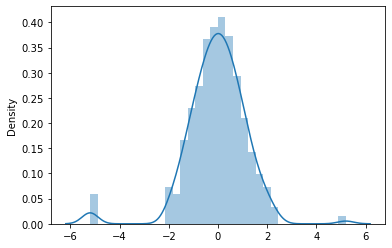

In [64]:
qt = QuantileTransformer(n_quantiles=100,
                         output_distribution='normal',
                         random_state=0)
qt_transf = qt.fit_transform(train["Fare"].values.reshape(-1, 1))
sns.distplot(qt_transf)

**What is the distribution of numerical feature values across the training dataset?**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

<li>Total samples in the training set are 668 or 51% of the actual number of passengers on board the Titanic (1,309).</li>
<li>Survived is a categorical feature with 0 or 1 values.</li>
<li>Around 59% of the passengers survived</li>
<li>Most passengers (> 75%) did not travel with parents or children.</li>
<li>Nearly 30% of the passengers had siblings and/or spouse aboard.</li>
<li>Fares varied significantly with few passengers (< 1%) paying as high as \$512</li>
<li>Few elderly passengers (< 1%) within age range 65-80. </li>

In [65]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,668,668,668,151,667
unique,668,2,544,119,3
top,"Nicholls, Mr. Joseph Charles",male,3101295,G6,S
freq,1,430,6,4,489


**What is the distribution of categorical features?**

<li>Names are unique across the dataset (count=unique=668)</li>
<li>Sex variable as two possible values with 64% male (top=male, freq=430/count=668).</li>
<li>Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.</li>
<li>Embarked takes three possible values. S port used by most passengers (top=S)</li>
<li>Ticket feature has high ratio (18.56%) of duplicate values (unique=544).</li>

## Bivariate Analysis

### Survived & Pclass

<AxesSubplot:xlabel='Survived', ylabel='%Survived'>

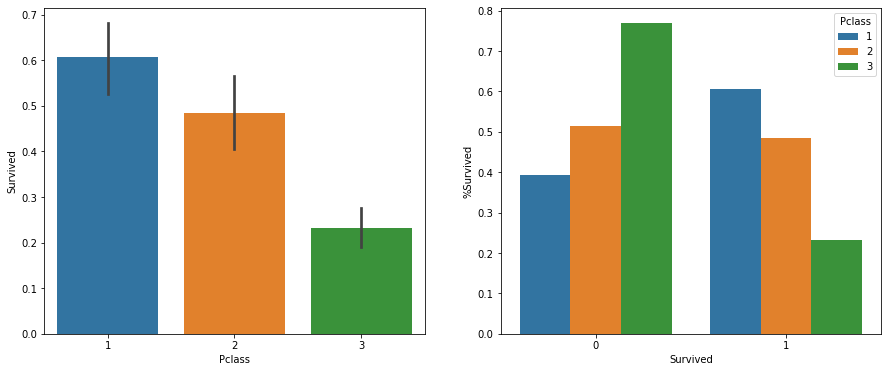

In [66]:
fig, axs = plt.subplots(figsize=[15, 6], ncols=2)
sns.barplot(x='Pclass', y='Survived', data=train, ax=axs[0])
prop_df = (train['Survived']
           .groupby(train['Pclass'])
           .value_counts(normalize=True)
           .rename('%Survived')
           .reset_index())
sns.barplot(x='Survived',
            y='%Survived',
            hue='Pclass',
            data=prop_df,
            ax=axs[1])

### Survived & Gender

<AxesSubplot:xlabel='Survived', ylabel='%Survived'>

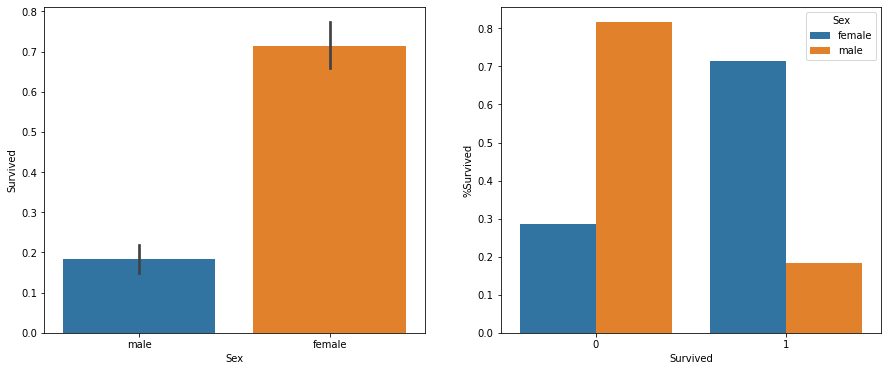

In [67]:
fig, axs = plt.subplots(figsize=[15, 6], ncols=2)
sns.barplot(x='Sex', y='Survived', data=train, ax=axs[0])
prop_df = (train['Survived']
           .groupby(train['Sex'])
           .value_counts(normalize=True)
           .rename('%Survived')
           .reset_index())
sns.barplot(x='Survived',
            y='%Survived',
            hue='Sex',
            data=prop_df,
            ax=axs[1])

### Survived & Embarked

<AxesSubplot:xlabel='Survived', ylabel='%Survived'>

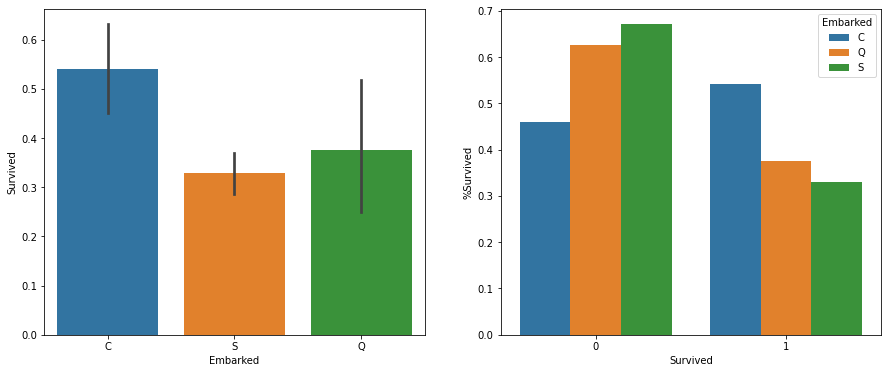

In [68]:
fig, axs = plt.subplots(figsize=[15, 6], ncols=2)
sns.barplot(x='Embarked', y='Survived', data=train, ax=axs[0])
prop_df = (train['Survived']
           .groupby(train['Embarked'])
           .value_counts(normalize=True)
           .rename('%Survived')
           .reset_index())
sns.barplot(x='Survived',
            y='%Survived',
            hue='Embarked',
            data=prop_df,
            ax=axs[1])

## Survived & Age 

<AxesSubplot:xlabel='Survived', ylabel='Age'>

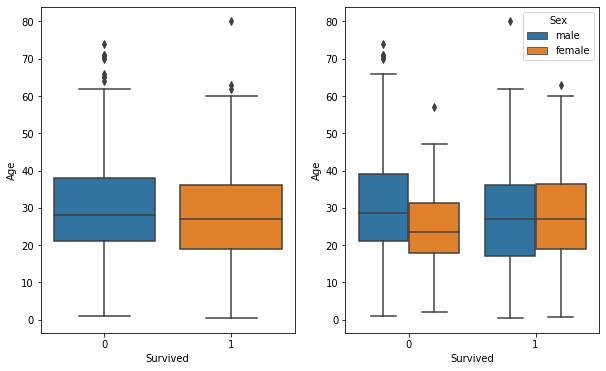

In [69]:
fig, axs = plt.subplots(figsize=[10, 6], ncols=2)
sns.boxplot(x='Survived', y='Age', data=train, ax=axs[0])
sns.boxplot(x='Survived', y='Age', hue='Sex', data=train, ax=axs[1])

## Survived & Fare

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

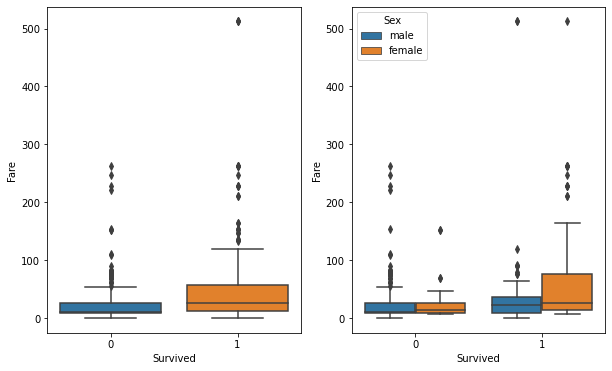

In [70]:
fig, axs = plt.subplots(figsize=[10, 6], ncols=2)
sns.boxplot(x='Survived', y='Fare', data=train, ax=axs[0])
sns.boxplot(x='Survived', y= 'Fare', hue='Sex', data= train, ax=axs[1])

### PClass & Fare

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

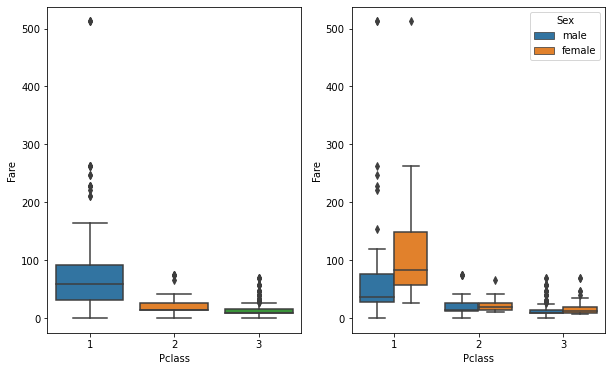

In [71]:
fig, axs = plt.subplots(figsize=[10, 6], ncols=2)
sns.boxplot(x='Pclass', y='Fare', data=train, ax=axs[0])
sns.boxplot(x='Pclass', y='Fare', hue='Sex', data=train, ax=axs[1])

### Age & Gender

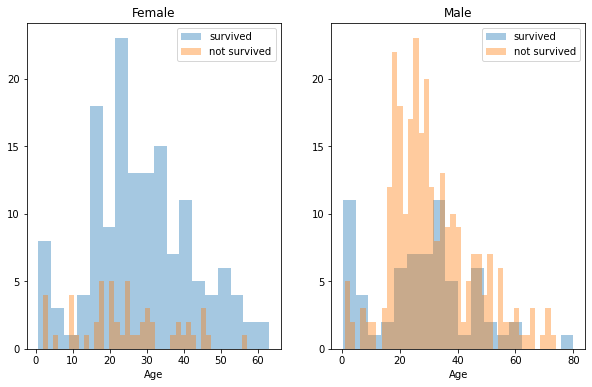

In [72]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(figsize=[10, 6], ncols=2)
women = train[train['Sex'] == 'female']
men = train[train['Sex'] == 'male']
ax = sns.distplot(women[women['Survived'] == 1].Age.dropna(),
                  bins=18, label=survived, ax=axes[0], kde=False)
ax = sns.distplot(women[women['Survived'] == 0].Age.dropna(),
                  bins=40, label=not_survived, ax=axes[0], kde=False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived'] == 1].Age.dropna(),
                  bins=18, label=survived, ax=axes[1], kde=False)
ax = sns.distplot(men[men['Survived'] == 0].Age.dropna(),
                  bins=40, label=not_survived, ax=axes[1], kde=False)
ax.legend()
_ = ax.set_title('Male')

### Embarked, Pclass and Sex

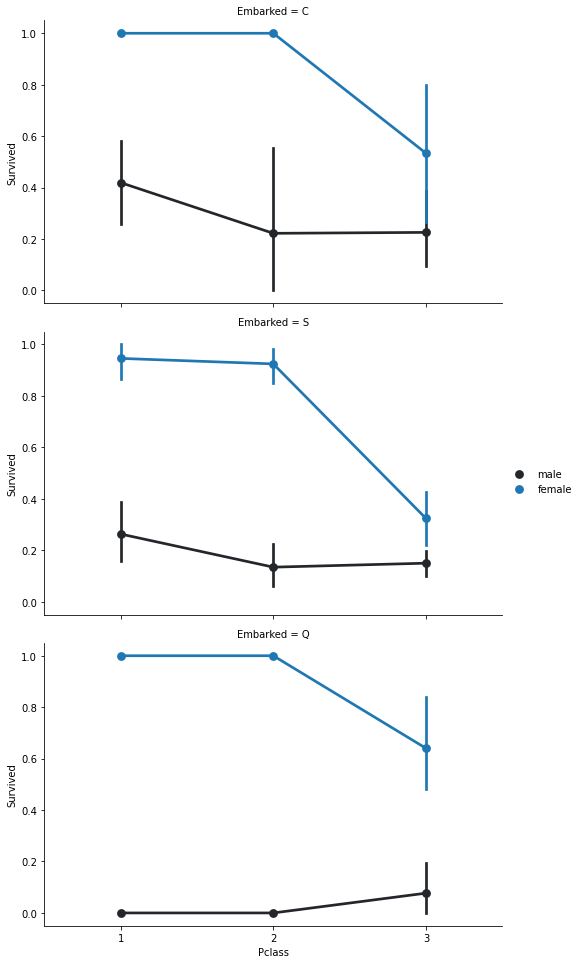

In [73]:
FacetGrid = sns.FacetGrid(train, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex',
              palette=None,  order=None, hue_order=None)
FacetGrid.add_legend()

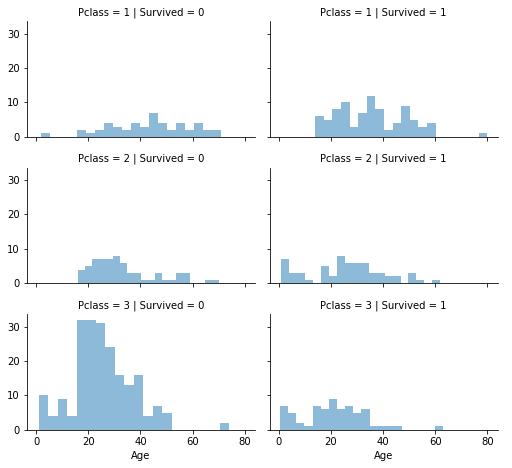

In [74]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

### Survived & Relatives 

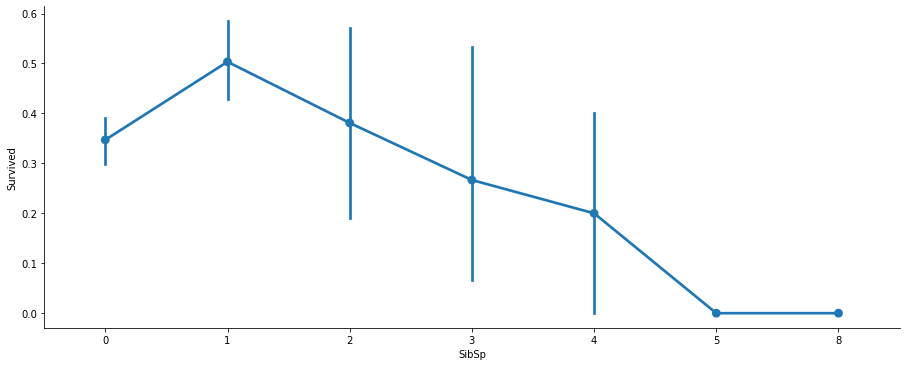

In [75]:
sns.factorplot('SibSp', 'Survived', data=train, aspect=2.5)

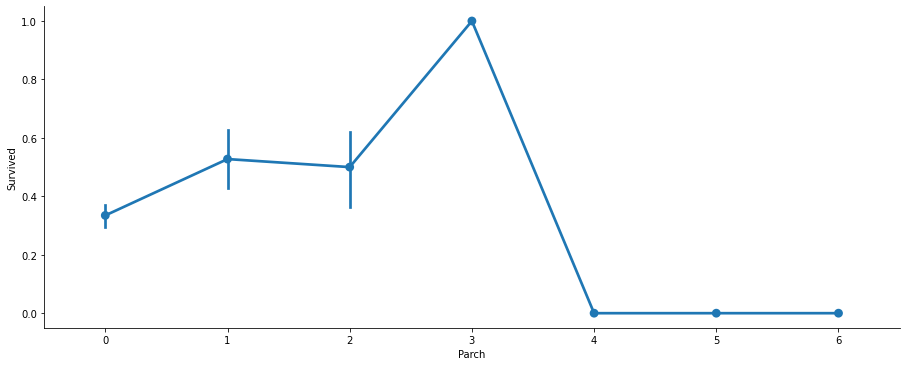

In [76]:
sns.factorplot('Parch', 'Survived', data=train, aspect=2.5)

# Data Preprocessing

In [77]:
trainPrepr = train.copy()

## Missing data

As a reminder, we have to deal with Cabin, Embarked and Age.

### Cabin

In [78]:
trainPrepr['InfoCabin'] = np.where(trainPrepr['Cabin'].isnull(), 0, 1)

In [79]:
trainPrepr['InfoCabin'].value_counts()

0    517
1    151
Name: InfoCabin, dtype: int64

Text(0.5, 1.0, 'InfoCabin')

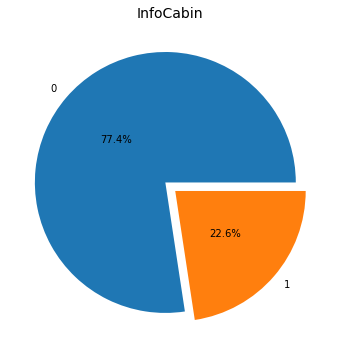

In [80]:
# grouping data by Survival type
data = trainPrepr.groupby("InfoCabin")["PassengerId"].count()

pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*2,
        labels=labels, pctdistance=0.5)
plt.title("InfoCabin", fontsize=14)

In [81]:
trainPrepr['Cabin'] = trainPrepr['Cabin'].astype(str)
trainPrepr['NbCabin'] = trainPrepr['Cabin'].str.split().apply(len)
trainPrepr.loc[trainPrepr.Cabin == 'nan', ['NbCabin']] = 0

In [82]:
trainPrepr['NbCabin'].value_counts()

0    517
1    133
2     11
3      5
4      2
Name: NbCabin, dtype: int64

Instead of deleting the `Cabin` variable we will extract the letter as it refers to the deck. Therefore we’re going to create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero.

In [83]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
trainPrepr['Deck'] = trainPrepr['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
trainPrepr['Deck'] = trainPrepr['Deck'].map(deck)
trainPrepr['Deck'] = trainPrepr['Deck'].fillna(0)
trainPrepr['Deck'] = trainPrepr['Deck'].astype(int)


In [84]:
trainPrepr.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,InfoCabin,NbCabin,Deck
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,nan,C,0,0,0
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,nan,S,0,0,0
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,nan,Q,0,0,0
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,1,1,2
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,nan,C,0,0,0


### Age

Let's deal with the issue with the age features missing values. We will create an array that contains random numbers, which are computed based on the mean age value in regards to the standard deviation and is_null.

In [85]:
mean = trainPrepr["Age"].mean()
std = trainPrepr["Age"].std()
is_null = trainPrepr["Age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size=is_null)
# fill NaN values in Age column with random values generated
age_slice = trainPrepr["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
trainPrepr["Age"] = age_slice
trainPrepr["Age"] = trainPrepr["Age"].astype(int)

### Embarked

For the Embarked feature, as it is a categorical variable, we are going to fill the missing values with the most common one.

In [86]:
trainPrepr['Embarked'] = trainPrepr['Embarked'].fillna(trainPrepr.Embarked.mode().iloc[0])

<AxesSubplot:>

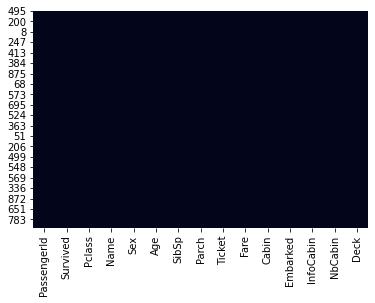

In [87]:
sns.heatmap(trainPrepr.isnull(), cbar=False)

## Converting Features

### Name

Let's use the Name feature to extract the Titles for each passenger.

In [88]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
# extract titles
trainPrepr['Title'] = trainPrepr.Name.str.extract(' ([A-Za-z]+)\.',
                                                  expand=False)
# replace titles with a more common title or as Rare
trainPrepr['Title'] = trainPrepr['Title'].replace(['Lady', 'Countess',
                                                   'Capt', 'Col',
                                                   'Don', 'Dr',
                                                   'Major', 'Rev',
                                                   'Sir', 'Jonkheer',
                                                   'Dona'],
                                                  'Rare')
trainPrepr['Title'] = trainPrepr['Title'].replace('Mlle', 'Miss')
trainPrepr['Title'] = trainPrepr['Title'].replace('Ms', 'Miss')
trainPrepr['Title'] = trainPrepr['Title'].replace('Mme', 'Mrs')
# convert titles into numbers
trainPrepr['Title'] = trainPrepr['Title'].map(titles)
# filling NaN with 0, to get safe
trainPrepr['Title'] = trainPrepr['Title'].fillna(0)

In [89]:
trainPrepr.Title.value_counts()

1    383
2    148
3     87
4     32
5     18
Name: Title, dtype: int64

### Sex

We are encoding Sex feature to convert it into numeric.

In [90]:
genders = {"male": 0, "female": 1}
trainPrepr['Sex'] = trainPrepr['Sex'].map(genders)

### Embarked

As we have done for Sex feature, let's do the same for Embarked.

In [91]:
ports = {"S": 0, "C": 1, "Q": 2}
trainPrepr['Embarked'] = trainPrepr['Embarked'].map(ports)

## Creating Categories

Age and fare features are float. We will now create categories from these features.

### Age Categorise

<AxesSubplot:ylabel='Density'>

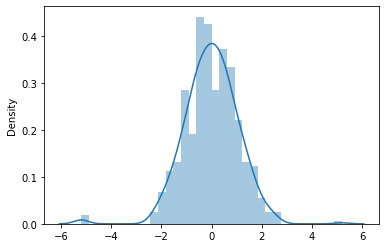

In [92]:
qt = QuantileTransformer(n_quantiles=100,
                         output_distribution='normal',
                         random_state=0)
qt_transf = qt.fit_transform(trainPrepr["Age"].values.reshape(-1, 1))
sns.distplot(qt_transf)

In [93]:
pd.Series(qt_transf.ravel()).describe()

count    668.000000
mean      -0.009281
std        1.066993
min       -5.199338
25%       -0.682458
50%        0.000000
75%        0.666564
max        5.199338
dtype: float64

In [94]:
c1 = min(qt_transf.ravel()) - 1
c2 = np.mean(qt_transf.ravel()) - np.std(qt_transf.ravel())
c3 = np.mean(qt_transf.ravel())
c4 = np.mean(qt_transf.ravel()) + np.std(qt_transf.ravel())
c5 = max(qt_transf.ravel()) + 1

bins = [c1, c2, c3, c4, c5]
trainPrepr['AgeCat'] = pd.cut(qt_transf.ravel(),
                              bins=bins,
                              labels=[0, 1, 2, 3])

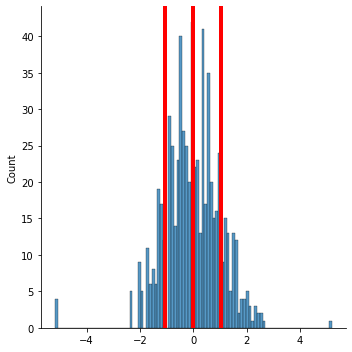

In [95]:
sns.displot(qt_transf.ravel(), bins=100)
plt.axvline(c2, linewidth=4, color='r')
plt.axvline(c3, linewidth=4, color='r')
plt.axvline(c4, linewidth=4, color='r')

Text(0.5, 1.0, 'AgeCat')

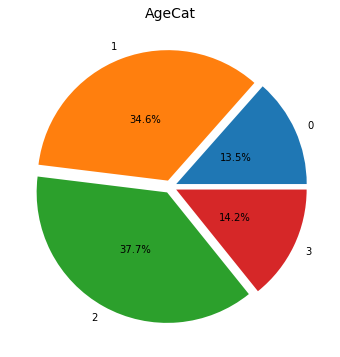

In [96]:
# grouping data by Survival type
data = trainPrepr.groupby("AgeCat")["PassengerId"].count()

pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*4,
        labels=labels, pctdistance=0.5)
plt.title("AgeCat", fontsize=14)

In [97]:
trainPrepr[['AgeCat', 'Survived']].groupby(['AgeCat'],
                                           as_index=False).mean().sort_values(by='AgeCat',
                                                                              ascending=True)

,AgeCat,Survived
0,0,0.500000
1,1,0.350649
2,2,0.345238
3,3,0.378947


### Fare Categorise

<AxesSubplot:ylabel='Density'>

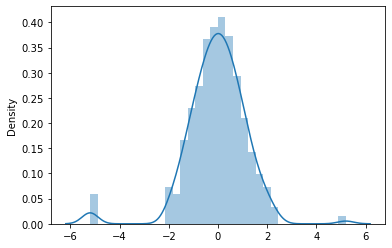

In [98]:
qt = QuantileTransformer(n_quantiles=100,
                         output_distribution='normal',
                         random_state=0)
qt_transf = qt.fit_transform(trainPrepr["Fare"].values.reshape(-1, 1))
sns.distplot(qt_transf)

In [99]:
pd.Series(qt_transf.ravel()).describe()

count    668.000000
mean      -0.040580
std        1.209485
min       -5.199338
25%       -0.666564
50%        0.012319
75%        0.680569
max        5.199338
dtype: float64

In [100]:
c1 = min(qt_transf.ravel()) - 1
c2 = np.mean(qt_transf.ravel()) - np.std(qt_transf.ravel())
c3 = np.mean(qt_transf.ravel())
c4 = np.mean(qt_transf.ravel()) + np.std(qt_transf.ravel())
c5 = max(qt_transf.ravel()) + 1

bins = [c1, c2, c3, c4, c5]
trainPrepr['FareCat'] = pd.cut(qt_transf.ravel(),
                              bins=bins,
                              labels=[0, 1 ,2, 3])

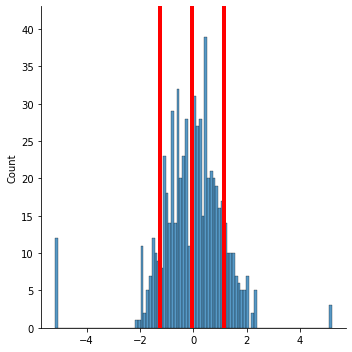

In [101]:
sns.displot(qt_transf.ravel(), bins=100)
plt.axvline(c2, linewidth=4, color='r')
plt.axvline(c3, linewidth=4, color='r')
plt.axvline(c4, linewidth=4, color='r')

Text(0.5, 1.0, 'FareCat')

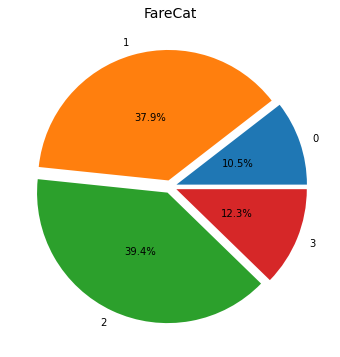

In [102]:
# grouping data by Survival type
data = trainPrepr.groupby("FareCat")["PassengerId"].count()

pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*4,
        labels=labels, pctdistance=0.5)
plt.title("FareCat", fontsize=14)

In [103]:
trainPrepr[['FareCat', 'Survived']].groupby(['FareCat'], as_index=False).mean().sort_values(by='FareCat', ascending=True)

,FareCat,Survived
0,0,0.142857
1,1,0.276680
2,2,0.425856
3,3,0.695122


## Creating new Features

![](http://)Though we have already created some new features in our dataset, we are going to add four (04) other variables to the dataset by combining some existing features: FamilySize; IsAlone; Age_Class and Fare_Per_Person.

### Family size

In [104]:
trainPrepr['FamilySize'] = trainPrepr['SibSp'] + trainPrepr['Parch'] + 1
trainPrepr[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
2,3,0.584416
3,4,0.562500
1,2,0.528455
6,7,0.428571
0,1,0.301980
4,5,0.200000
5,6,0.142857
7,8,0.000000
8,11,0.000000


<AxesSubplot:xlabel='FamilySize', ylabel='count'>

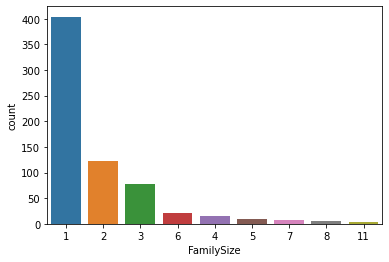

In [105]:
sns.countplot(data=trainPrepr, x='FamilySize', order=trainPrepr.FamilySize.value_counts().index)

<AxesSubplot:xlabel='FamilySizeCat', ylabel='count'>

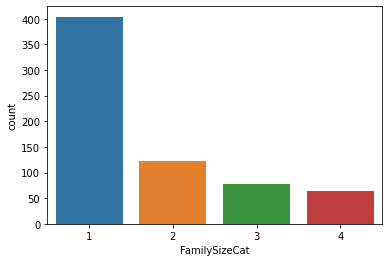

In [106]:
trainPrepr['FamilySizeCat'] = trainPrepr['FamilySize']
trainPrepr.loc[trainPrepr['FamilySizeCat'] > 3, ['FamilySizeCat']] = 4
sns.countplot(data=trainPrepr, x='FamilySizeCat',
              order=trainPrepr.FamilySizeCat.value_counts().index)

### Is alone

In [107]:
trainPrepr['IsAlone'] = 0
trainPrepr.loc[trainPrepr['FamilySize'] == 1, 'IsAlone'] = 1

trainPrepr[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.481061
1,1,0.301980


Text(0.5, 1.0, 'IsAlone')

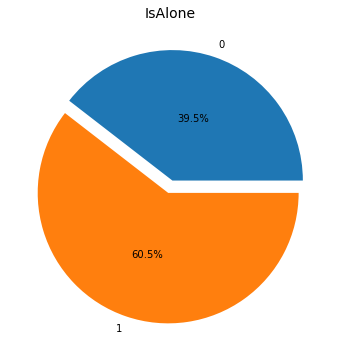

In [108]:
# grouping data by Survival type
data = trainPrepr.groupby("IsAlone")["PassengerId"].count()

pie, ax = plt.subplots(figsize=[10, 6])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("IsAlone", fontsize=14)

###  Age times Class

In [109]:
trainPrepr['Age_Class']= trainPrepr['Age'] * trainPrepr['Pclass'] 

<AxesSubplot:xlabel='Age_Class', ylabel='Density'>

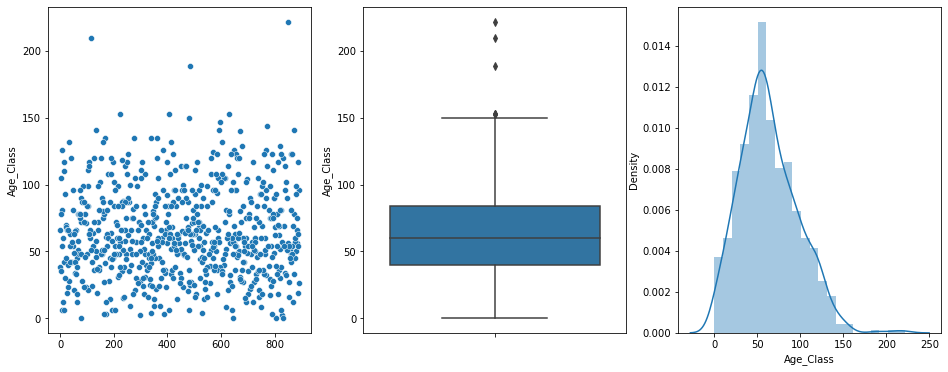

In [110]:
fig, axs = plt.subplots(figsize=[16, 6], ncols=3)
sns.scatterplot(data=trainPrepr["Age_Class"], ax=axs[0])
sns.boxplot(y=trainPrepr["Age_Class"], ax=axs[1])
sns.distplot(trainPrepr["Age_Class"], ax=axs[2])

### Fare per Person

In [111]:
trainPrepr['Fare_Per_Person'] = trainPrepr['Fare']/(trainPrepr['FamilySize'])
trainPrepr['Fare_Per_Person'] = trainPrepr['Fare_Per_Person'].astype(int)

<AxesSubplot:xlabel='Fare_Per_Person', ylabel='Density'>

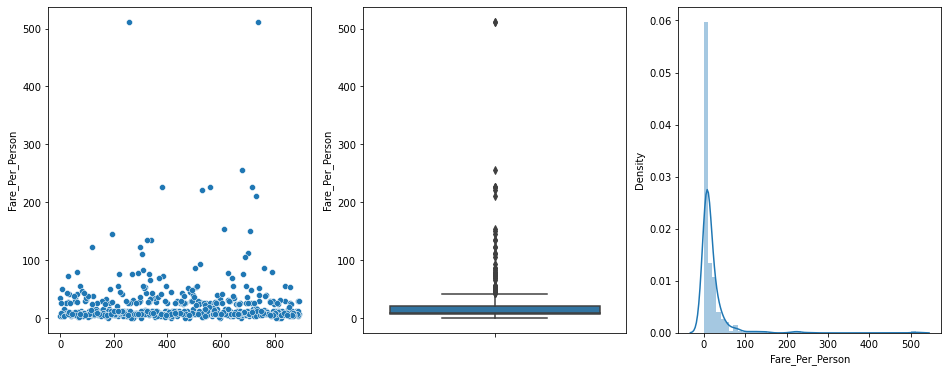

In [112]:
fig, axs = plt.subplots(figsize=[16, 6], ncols=3)
sns.scatterplot(data=trainPrepr["Fare_Per_Person"], ax=axs[0])
sns.boxplot(y=trainPrepr["Fare_Per_Person"], ax=axs[1])
sns.distplot(trainPrepr["Fare_Per_Person"], ax=axs[2])

In [113]:
# Let's take a last look at the training set, 
# before we start training the models.
trainPrepr.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,NbCabin,Deck,Title,AgeCat,FareCat,FamilySize,FamilySizeCat,IsAlone,Age_Class,Fare_Per_Person
495,496,0,3,"Yousseff, Mr. Gerious",0,27,0,0,2627,14.4583,...,0,0,1,1,2,1,1,1,81,14
648,649,0,3,"Willey, Mr. Edward",0,42,0,0,S.O./P.P. 751,7.5500,...,0,0,1,2,0,1,1,1,126,7
278,279,0,3,"Rice, Master. Eric",0,7,4,1,382652,29.1250,...,0,0,4,0,2,6,4,0,21,4
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",1,23,1,0,PC 17569,146.5208,...,1,2,3,1,3,2,2,0,23,73
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",1,29,0,2,2650,15.2458,...,0,0,3,2,2,3,3,0,87,5
298,299,1,1,"Saalfeld, Mr. Adolphe",0,28,0,0,19988,30.5000,...,1,3,1,2,2,1,1,1,28,30
609,610,1,1,"Shutes, Miss. Elizabeth W",1,40,0,0,PC 17582,153.4625,...,1,3,2,2,3,1,1,1,40,153
318,319,1,1,"Wick, Miss. Mary Natalie",1,31,0,2,36928,164.8667,...,1,3,2,2,3,3,3,0,31,54
484,485,1,1,"Bishop, Mr. Dickinson H",0,25,1,0,11967,91.0792,...,1,2,1,1,3,2,2,0,25,45
367,368,1,3,"Moussa, Mrs. (Mantoura Boulos)",1,15,0,0,2626,7.2292,...,0,0,3,0,0,1,1,1,45,7


## Drop Variables

Let's drop useless features for our training models.

In [114]:
trainPrepr = trainPrepr.drop(['PassengerId', 'Name',
                              'Ticket', 'Cabin'], axis=1)

In [115]:
trainPrepr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 495 to 539
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Survived         668 non-null    int64   
 1   Pclass           668 non-null    int64   
 2   Sex              668 non-null    int64   
 3   Age              668 non-null    int64   
 4   SibSp            668 non-null    int64   
 5   Parch            668 non-null    int64   
 6   Fare             668 non-null    float64 
 7   Embarked         668 non-null    int64   
 8   InfoCabin        668 non-null    int64   
 9   NbCabin          668 non-null    int64   
 10  Deck             668 non-null    int64   
 11  Title            668 non-null    int64   
 12  AgeCat           668 non-null    category
 13  FareCat          668 non-null    category
 14  FamilySize       668 non-null    int64   
 15  FamilySizeCat    668 non-null    int64   
 16  IsAlone          668 non-null    int64   


### Encoding Variables

Pclass, Embarked and Title features have to be encoded and not be treated as numeric. 

In [116]:
trainPrepr['Pclass'] = trainPrepr['Pclass'].astype(str)
trainPrepr['Embarked'] = trainPrepr['Embarked'].astype(str)
trainPrepr['Title'] = trainPrepr['Title'].astype(str)
TrainFinal = pd.get_dummies(trainPrepr,
                            columns=['Pclass', 'Embarked', 'Title'],
                            prefix=['Pclass', 'Embarked', 'Title'],
                            drop_first=True)

In [117]:
print(TrainFinal.shape)
TrainFinal.head()

(668, 24)


,Survived,Sex,Age,SibSp,Parch,Fare,InfoCabin,NbCabin,Deck,AgeCat,...,Age_Class,Fare_Per_Person,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Title_2,Title_3,Title_4,Title_5
495,0,0,27,0,0,14.4583,0,0,0,1,...,81,14,0,1,1,0,0,0,0,0
648,0,0,42,0,0,7.5500,0,0,0,2,...,126,7,0,1,0,0,0,0,0,0
278,0,0,7,4,1,29.1250,0,0,0,0,...,21,4,0,1,0,1,0,0,1,0
31,1,1,23,1,0,146.5208,1,1,2,1,...,23,73,0,0,1,0,0,1,0,0
255,1,1,29,0,2,15.2458,0,0,0,2,...,87,5,0,1,1,0,0,1,0,0


In [118]:
TrainFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 495 to 539
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Survived         668 non-null    int64   
 1   Sex              668 non-null    int64   
 2   Age              668 non-null    int64   
 3   SibSp            668 non-null    int64   
 4   Parch            668 non-null    int64   
 5   Fare             668 non-null    float64 
 6   InfoCabin        668 non-null    int64   
 7   NbCabin          668 non-null    int64   
 8   Deck             668 non-null    int64   
 9   AgeCat           668 non-null    category
 10  FareCat          668 non-null    category
 11  FamilySize       668 non-null    int64   
 12  FamilySizeCat    668 non-null    int64   
 13  IsAlone          668 non-null    int64   
 14  Age_Class        668 non-null    int64   
 15  Fare_Per_Person  668 non-null    int64   
 16  Pclass_2         668 non-null    uint8   


# Custom Transformer & Pipeline of transformation

In [119]:
from sklearn.pipeline import Pipeline


class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

In [120]:
# this function takes a dataframe as input and
# returns a modified version thereof
def process_dataframe(input_df):
    
    input_df['InfoCabin'] = np.where(input_df['Cabin'].isnull(), 0, 1)
    input_df['Cabin'] = input_df['Cabin'].astype(str)
    input_df['NbCabin'] = input_df['Cabin'].str.split().apply(len)
    input_df.loc[input_df.Cabin == 'nan', ['NbCabin']] = 0
    
    deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    input_df['Deck'] = input_df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    input_df['Deck'] = input_df['Deck'].map(deck)
    input_df['Deck'] = input_df['Deck'].fillna(0)
    input_df['Deck'] = input_df['Deck'].astype(int)
    
    mean = input_df["Age"].mean()
    std = input_df["Age"].std()
    is_null = input_df["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size=is_null)
    # fill NaN values in Age column with random values generated
    age_slice = input_df["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    input_df["Age"] = age_slice
    input_df["Age"] = input_df["Age"].astype(int)
    
    meanFare = input_df["Fare"].mean()
    stdFare = input_df["Fare"].std()
    is_nullFare = input_df["Fare"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_Fare = np.random.randint(meanFare - stdFare,
                                  meanFare + stdFare,
                                  size=is_nullFare)
    # fill NaN values in Age column with random values generated
    Fare_slice = input_df["Fare"].copy()
    Fare_slice[np.isnan(Fare_slice)] = rand_Fare
    input_df["Fare"] = Fare_slice
    input_df["Fare"] = input_df["Fare"].astype(int)
    
    input_df['Embarked'] = input_df['Embarked'].fillna(input_df.Embarked.mode().iloc[0])
    input_df['Pclass'] = input_df['Pclass'].fillna(input_df.Pclass.mode().iloc[0])
    input_df['Sex'] = input_df['Sex'].fillna(input_df.Sex.mode().iloc[0])
    input_df['SibSp'] = input_df['SibSp'].fillna(input_df.SibSp.mode().iloc[0])
    input_df['Parch'] = input_df['Parch'].fillna(input_df.Parch.mode().iloc[0])
    
    titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    # extract titles
    input_df['Title'] = input_df.Name.str.extract(' ([A-Za-z]+)\.',
                                                  expand=False)
    # replace titles with a more common title or as Rare
    input_df['Title'] = input_df['Title'].replace(['Lady', 'Countess',
                                                   'Capt', 'Col', 'Don',
                                                   'Dr', 'Major',
                                                   'Rev', 'Sir',
                                                   'Jonkheer', 'Dona'],
                                                  'Rare')
    input_df['Title'] = input_df['Title'].replace('Mlle', 'Miss')
    input_df['Title'] = input_df['Title'].replace('Ms', 'Miss')
    input_df['Title'] = input_df['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    input_df['Title'] = input_df['Title'].map(titles)
    # filling NaN with 0, to get safe
    input_df['Title'] = input_df['Title'].fillna(0)
    
    genders = {"male": 0, "female": 1}
    input_df['Sex'] = input_df['Sex'].map(genders)
    
    ports = {"S": 0, "C": 1, "Q": 2}
    input_df['Embarked'] = input_df['Embarked'].map(ports)
    
    qt = QuantileTransformer(n_quantiles=100,
                             output_distribution='normal',
                             random_state=0)
    qt_transf_Age = qt.fit_transform(input_df["Age"].values.reshape(-1, 1))
    c1 = min(qt_transf_Age.ravel()) - 1
    c2 = np.mean(qt_transf_Age.ravel()) - np.std(qt_transf_Age.ravel())
    c3 = np.mean(qt_transf_Age.ravel())
    c4 = np.mean(qt_transf_Age.ravel()) + np.std(qt_transf_Age.ravel())
    c5 = max(qt_transf_Age.ravel()) + 1

    bins = [c1, c2, c3, c4, c5]
    input_df['AgeCat'] = pd.cut(qt_transf_Age.ravel(),
                                bins=bins,
                                labels=[0, 1, 2, 3])
    
    input_df['AgeCat'] = input_df['AgeCat'].astype(int)
    
    qt_transf_Fare = qt.fit_transform(input_df["Fare"].values.reshape(-1, 1))
    c1 = min(qt_transf_Fare.ravel()) - 1
    c2 = np.mean(qt_transf_Fare.ravel()) - np.std(qt_transf_Fare.ravel())
    c3 = np.mean(qt_transf_Fare.ravel())
    c4 = np.mean(qt_transf_Fare.ravel()) + np.std(qt_transf_Fare.ravel())
    c5 = max(qt_transf_Fare.ravel()) + 1

    bins = [c1, c2, c3, c4, c5]
    input_df['FareCat'] = pd.cut(qt_transf_Fare.ravel(),
                                 bins=bins,
                                 labels=[0, 1, 2, 3])
    
    input_df['FareCat'] = input_df['FareCat'].astype(int)
    
    input_df['FamilySize'] = input_df['SibSp'] + input_df['Parch'] + 1
    input_df['FamilySizeCat'] = input_df['FamilySize']
    input_df.loc[input_df['FamilySizeCat'] > 3, ['FamilySizeCat']] = 4
    
    input_df['IsAlone'] = 0
    input_df.loc[input_df['FamilySize'] == 1, 'IsAlone'] = 1
    
    input_df['Age_Class'] = input_df['Age'] * input_df['Pclass']
    
    input_df['Fare_Per_Person'] = input_df['Fare'] / (input_df['FamilySize'])
    input_df['Fare_Per_Person'] = input_df['Fare_Per_Person'].astype(int)
    
    input_df = input_df.drop(['PassengerId', 'Name',
                              'Ticket', 'Cabin'], axis=1)
    
    input_df['Pclass'] = input_df['Pclass'].astype(str)
    input_df['Embarked'] = input_df['Embarked'].astype(str)
    input_df['Title'] = input_df['Title'].astype(str)
    input_df = pd.get_dummies(input_df,
                              columns=['Pclass', 'Embarked', 'Title'],
                              prefix=['Pclass', 'Embarked', 'Title'],
                              drop_first=True)
    col = input_df.columns.tolist()
    colNum = []
    for elem in col:
        if max(input_df[elem]) > 1:
            colNum.append(elem)
    for elem in colNum:
        scaler = MinMaxScaler()
        input_df[elem] = scaler.fit_transform(input_df[elem].values.reshape(-1, 1))
    return input_df

In [121]:
# this pipeline has a single step
pipeline = Pipeline([
    ("transform", DataframeFunctionTransformer(process_dataframe))
])

In [122]:
# apply the pipeline to the input dataframe
trainData = pipeline.fit_transform(trainData)

In [123]:
trainData.head(10)

,Survived,Sex,Age,SibSp,Parch,Fare,InfoCabin,NbCabin,Deck,AgeCat,...,Age_Class,Fare_Per_Person,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Title_2,Title_3,Title_4,Title_5
495,0,0,0.2375,0.000,0.000000,0.027344,0,0.00,0.000000,0.333333,...,0.256757,0.027344,0,1,1,0,0,0,0,0
648,0,0,0.3625,0.000,0.000000,0.013672,0,0.00,0.000000,0.666667,...,0.391892,0.013672,0,1,0,0,0,0,0,0
278,0,0,0.0875,0.500,0.166667,0.056641,0,0.00,0.000000,0.000000,...,0.094595,0.007812,0,1,0,1,0,0,1,0
31,1,1,0.2000,0.125,0.000000,0.285156,1,0.25,0.285714,0.000000,...,0.072072,0.142578,0,0,1,0,0,1,0,0
255,1,1,0.3625,0.000,0.333333,0.029297,0,0.00,0.000000,0.666667,...,0.391892,0.009766,0,1,1,0,0,1,0,0
298,1,0,0.2125,0.000,0.000000,0.058594,1,0.25,0.428571,0.333333,...,0.076577,0.058594,0,0,0,0,0,0,0,0
609,1,1,0.5000,0.000,0.000000,0.298828,1,0.25,0.428571,0.666667,...,0.180180,0.298828,0,0,0,0,1,0,0,0
318,1,1,0.3875,0.000,0.333333,0.320312,1,0.25,0.428571,0.666667,...,0.139640,0.105469,0,0,0,0,1,0,0,0
484,1,0,0.3125,0.125,0.000000,0.177734,1,0.25,0.285714,0.333333,...,0.112613,0.087891,0,0,1,0,0,0,0,0
367,1,1,0.4750,0.000,0.000000,0.013672,0,0.00,0.000000,0.666667,...,0.513514,0.013672,0,1,1,0,0,1,0,0


In [124]:
trainData.describe()

,Survived,Sex,Age,SibSp,Parch,Fare,InfoCabin,NbCabin,Deck,AgeCat,...,Age_Class,Fare_Per_Person,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Title_2,Title_3,Title_4,Title_5
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,...,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,0.372754,0.356287,0.363436,0.065681,0.060629,0.062643,0.226048,0.066617,0.109068,0.507984,...,0.286670,0.039285,0.203593,0.556886,0.182635,0.083832,0.221557,0.130240,0.047904,0.026946
std,0.483900,0.479260,0.167540,0.137116,0.129487,0.103383,0.418584,0.139126,0.225275,0.297308,...,0.150544,0.077218,0.402971,0.497126,0.386656,0.277344,0.415606,0.336819,0.213724,0.162047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.259375,0.000000,0.000000,0.013672,0.000000,0.000000,0.000000,0.333333,...,0.183559,0.013672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.350000,0.000000,0.000000,0.027344,0.000000,0.000000,0.000000,0.666667,...,0.270270,0.015625,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.462500,0.125000,0.000000,0.058594,0.000000,0.000000,0.000000,0.666667,...,0.378378,0.041504,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

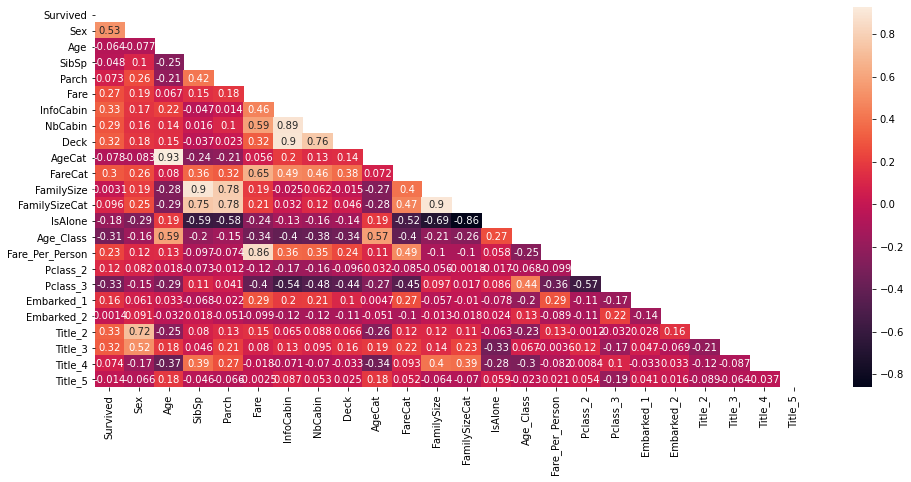

In [125]:
plt.figure(figsize=(16, 7))

cor = trainData.corr()
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cor, mask=mask, annot=True)

In [126]:
valData = pipeline.transform(valData)

In [127]:
valData.head()

,Survived,Sex,Age,SibSp,Parch,Fare,InfoCabin,NbCabin,Deck,AgeCat,...,Age_Class,Fare_Per_Person,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Title_2,Title_3,Title_4,Title_5
9,1,1,0.200000,0.125,0.0,0.114068,0,0.000000,0.000000,0.000000,...,0.143590,0.111111,1,0,1,0,0,1,0,0
11,1,1,0.828571,0.000,0.0,0.098859,1,0.333333,0.500000,1.000000,...,0.297436,0.192593,0,0,0,0,1,0,0,0
19,1,1,0.500000,0.000,0.0,0.026616,0,0.000000,0.000000,0.666667,...,0.538462,0.051852,0,1,1,0,0,1,0,0
23,1,0,0.400000,0.000,0.0,0.133080,1,0.333333,0.166667,0.333333,...,0.143590,0.259259,0,0,0,0,0,0,0,0
24,0,1,0.114286,0.375,0.2,0.079848,0,0.000000,0.000000,0.000000,...,0.123077,0.029630,0,1,0,0,1,0,0,0


# Building Machine Learning Models

In [128]:
X_train = trainData.drop("Survived", axis=1)
Y_train = trainData["Survived"]
X_val = valData.drop("Survived", axis=1)
Y_val = valData["Survived"]


## Stochastic Gradient Descent (SGD)

In [129]:
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)

score = round(sgd.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  81.44


In [130]:
# Predicting and accuracy check
Y_pred = sgd.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[117  13]
 [ 43  50]]


<AxesSubplot:>

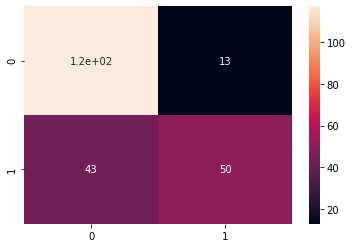

In [131]:
sns.heatmap(cm, annot=True)

In [132]:
cr = classification_report(Y_val, Y_pred)
acc_sgd = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.73      0.90      0.81       130
           1       0.79      0.54      0.64        93

    accuracy                           0.75       223
   macro avg       0.76      0.72      0.72       223
weighted avg       0.76      0.75      0.74       223



## Random Forest

In [133]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

score = round(random_forest.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  97.46


In [134]:
# Predicting and accuracy check
Y_pred = random_forest.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[119  11]
 [ 29  64]]


<AxesSubplot:>

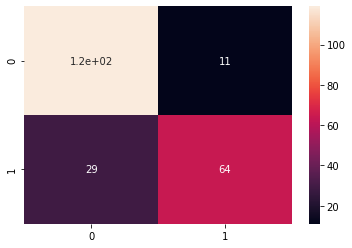

In [135]:
sns.heatmap(cm, annot=True)

In [136]:
cr = classification_report(Y_val, Y_pred)
acc_random_forest = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       130
           1       0.85      0.69      0.76        93

    accuracy                           0.82       223
   macro avg       0.83      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



## Logistic Regression

In [137]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

score = round(logreg.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  83.68


In [138]:
# Predicting and accuracy check
Y_pred = logreg.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[119  11]
 [ 26  67]]


<AxesSubplot:>

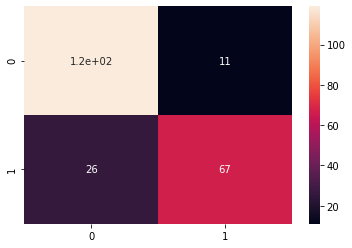

In [139]:
sns.heatmap(cm, annot=True)

In [140]:
cr = classification_report(Y_val, Y_pred)
acc_log = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       130
           1       0.86      0.72      0.78        93

    accuracy                           0.83       223
   macro avg       0.84      0.82      0.82       223
weighted avg       0.84      0.83      0.83       223



## K Nearest Neighbor

In [141]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

score = round(knn.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  89.37


In [142]:
# Predicting and accuracy check
Y_pred = knn.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[113  17]
 [ 29  64]]


<AxesSubplot:>

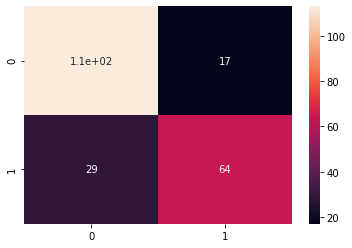

In [143]:
sns.heatmap(cm, annot=True)

In [144]:
cr = classification_report(Y_val, Y_pred)
acc_knn = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       130
           1       0.79      0.69      0.74        93

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



## Gaussian Naive Bayes

In [145]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)

score = round(gaussian.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  79.19


In [146]:
# Predicting and accuracy check
Y_pred = gaussian.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[99 31]
 [23 70]]


<AxesSubplot:>

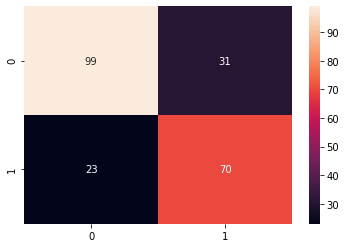

In [147]:
sns.heatmap(cm, annot=True)

In [148]:
cr = classification_report(Y_val, Y_pred)
acc_gaussian = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       130
           1       0.69      0.75      0.72        93

    accuracy                           0.76       223
   macro avg       0.75      0.76      0.75       223
weighted avg       0.76      0.76      0.76       223



## Perceptron

In [149]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

score = round(perceptron.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  46.11


In [150]:
# Predicting and accuracy check
Y_pred = perceptron.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[ 21 109]
 [  5  88]]


<AxesSubplot:>

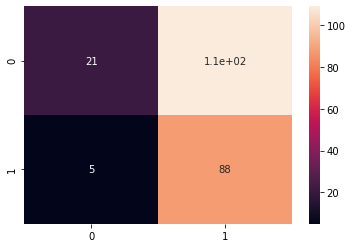

In [151]:
sns.heatmap(cm, annot=True)

In [152]:
cr = classification_report(Y_val, Y_pred)
acc_perceptron = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.16      0.27       130
           1       0.45      0.95      0.61        93

    accuracy                           0.49       223
   macro avg       0.63      0.55      0.44       223
weighted avg       0.66      0.49      0.41       223



## Linear Support Vector Machine

In [153]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

score = round(linear_svc.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  83.23


In [154]:
# Predicting and accuracy check
Y_pred = linear_svc.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[120  10]
 [ 24  69]]


<AxesSubplot:>

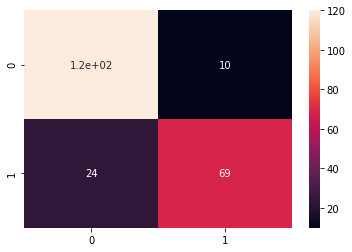

In [155]:
sns.heatmap(cm, annot=True)

In [156]:
cr = classification_report(Y_val, Y_pred)
acc_linear_svc = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.92      0.88       130
           1       0.87      0.74      0.80        93

    accuracy                           0.85       223
   macro avg       0.85      0.83      0.84       223
weighted avg       0.85      0.85      0.85       223



## Decision Tree

In [157]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  

score = round(decision_tree.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  97.46


In [158]:
# Predicting and accuracy check
Y_pred = decision_tree.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[106  24]
 [ 42  51]]


<AxesSubplot:>

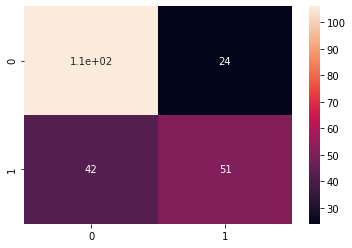

In [159]:
sns.heatmap(cm, annot=True)

In [160]:
cr = classification_report(Y_val, Y_pred)
acc_decision_tree = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.72      0.82      0.76       130
           1       0.68      0.55      0.61        93

    accuracy                           0.70       223
   macro avg       0.70      0.68      0.68       223
weighted avg       0.70      0.70      0.70       223



## Voting 

In [161]:
voting_clf = VotingClassifier(estimators=[('SGD', sgd),
                                          ('RF', random_forest),
                                          ('LR', logreg),
                                          ('KNN', knn),
                                          ('NaiveBayes', gaussian),
                                          ('Perceptron', perceptron),
                                          ('SVC', linear_svc),
                                          ('DT', decision_tree)],
                              voting='hard')
voting_clf.fit(X_train, Y_train)


score = round(voting_clf.score(X_train, Y_train) * 100, 2)
print("Training score: ", score)

Training score:  89.52


In [162]:
# Predicting and accuracy check
Y_pred = voting_clf.predict(X_val)

cm = confusion_matrix(Y_val, Y_pred)
print(cm)

[[117  13]
 [ 32  61]]


<AxesSubplot:>

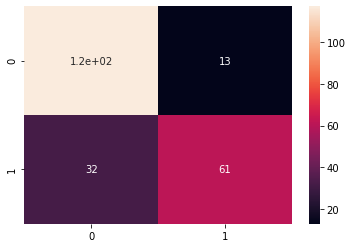

In [163]:
sns.heatmap(cm, annot=True)

In [164]:
cr = classification_report(Y_val, Y_pred)
acc_voting_clf = f1_score(Y_pred, Y_val, average='macro')
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       130
           1       0.82      0.66      0.73        93

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.78       223
weighted avg       0.80      0.80      0.79       223



Now let's order the models we have chosen to implement base on their f1score.

# Best Model

In [165]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent',
              'Decision Tree', 'Voting'],
    'Score': [acc_linear_svc, acc_knn, acc_log,
              acc_random_forest, acc_gaussian, acc_perceptron,
              acc_sgd, acc_decision_tree, acc_voting_clf]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
0.839119,Support Vector Machines
0.824540,Logistic Regression
0.809010,Random Forest
0.784624,Voting
0.783257,KNN
0.753682,Naive Bayes
0.723961,Stochastic Gradient Decent
0.684866,Decision Tree
0.438064,Perceptron


We can see that SVM perform better than the voting model (83.47% VS 79.85%). And the different scores are somehow high. We can be happy and stop here. But we can also criticize our method of splitting the training dataset into train and validation sets: 
<ul>
    <li>We do not have enough data in the trainind dataset to do that.</li>
    <li>What if the spliting haven't captured the structure of data. We could end-up with an easy validation set to predict.</li>
</ul>

To try to resolve these issues, we are going to implement the K-fold cross validation and also we are going to tuning some parameters in the models to make them perform better.

In [166]:
%pycodestyle_off

# K-Fold Cross Validation & Hyper-parameter tuning

In [167]:
# the metric we are using
f1 = make_scorer(f1_score, average='macro')

In [168]:
# Apply the pipeline to the input dataframe
# We are using train_set dataset that corresponds
# to the original train set without being split.

train_set_tr = pipeline.fit_transform(train_set)

In [169]:
train_set_tr.head()

,Survived,Sex,Age,SibSp,Parch,Fare,InfoCabin,NbCabin,Deck,AgeCat,...,Age_Class,Fare_Per_Person,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Title_2,Title_3,Title_4,Title_5
0,0,0,0.2750,0.125,0.0,0.013672,0,0.00,0.000000,0.333333,...,0.297297,0.005859,0,1,0,0,0,0,0,0
1,1,1,0.4750,0.125,0.0,0.138672,1,0.25,0.428571,0.666667,...,0.171171,0.068359,0,0,1,0,0,1,0,0
2,1,1,0.3250,0.000,0.0,0.013672,0,0.00,0.000000,0.333333,...,0.351351,0.013672,0,1,0,0,1,0,0,0
3,1,1,0.4375,0.125,0.0,0.103516,1,0.25,0.428571,0.666667,...,0.157658,0.050781,0,0,0,0,0,1,0,0
4,0,0,0.4375,0.000,0.0,0.015625,0,0.00,0.000000,0.666667,...,0.472973,0.015625,0,1,0,0,0,0,0,0


In [170]:
X_train = train_set_tr.drop("Survived", axis=1)
Y_train = train_set_tr["Survived"]

## Stochastic Gradient Descent (SGD)

In [171]:
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],  # learning rate
              'tol': [1e-4, 1e-3, 1e-2, 1e-1],
              'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],  # logistic regression
              'penalty': ['l2', 'l1', 'elasticnet'],
              'random_state' : [1]}

sgd = SGDClassifier()
sgd_clf = GridSearchCV(estimator=sgd, param_grid=param_grid, cv = 10, scoring = f1, n_jobs=-1)
sgd_clf.fit(X_train, Y_train)
sgd_clf.best_params_

{'alpha': 0.001,
 'loss': 'log',
 'penalty': 'l2',
 'random_state': 1,
 'tol': 0.0001}

In [172]:
acc_sgd2 = sgd_clf.best_score_
print("Training score: ", acc_sgd2)

Training score:  0.820684961133735


### Random Forest

In [173]:
param_grid = {"criterion" : ["gini", "entropy"],
              "n_estimators": [i for i in range(50, 250, 50)],
              "max_depth": [i for i in range(5, 25, 2)],
              "min_samples_split" : [12, 16, 18, 25, 35],
              'oob_score' : [True],
              'random_state' : [1],
              'n_jobs' : [-1]}

rf = RandomForestClassifier()
rf_clf = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 10, scoring = f1, n_jobs=-1)
rf_clf.fit(X_train, Y_train)
rf_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_split': 16,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 1}

In [174]:
acc_random_forest2 = rf_clf.best_score_
print("Training score: ", acc_random_forest2)

Training score:  0.8296055116397817


## Logistic Regression

In [175]:
param_grid = {'tol': [1e-4, 1e-3, 1e-2, 1e-1],
              "C":[i for i in range(7, 20, 2)],
              "penalty": ["l1","l2"],  # l1 lasso l2 ridge
              'solver' : ['lbfgs', 'liblinear'],
              'max_iter' : [i for i in range(100, 1000, 100)],
              'random_state' : [1]
             }

logreg = LogisticRegression()
logreg_clf = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=10, scoring = f1, n_jobs=-1)
logreg_clf.fit(X_train, Y_train)
logreg_clf.best_params_

{'C': 15,
 'max_iter': 100,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'liblinear',
 'tol': 0.01}

In [176]:
acc_log2 = logreg_clf.best_score_
print("Training score: ", acc_log2)

Training score:  0.8224383978610474


## K Nearest Neighbor

In [177]:
param_grid = {"weights": ["uniform", "distance"],
              'n_neighbors': [3, 5, 7, 9, 11, 13, 15]  # usually odd numbers
             }

knn = KNeighborsClassifier()
knn_clf = GridSearchCV(estimator=knn, param_grid=param_grid,
                       cv=10, scoring=f1, n_jobs=-1)
knn_clf.fit(X_train, Y_train)
knn_clf.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

In [178]:
acc_knn2 = knn_clf.best_score_
print("Training score: ", acc_knn2)

Training score:  0.7965742097974753


## Perceptron

In [179]:
param_grid = {'eta0' : [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10],
              'max_iter' : [i for i in range(500, 2000, 500)],
              'random_state' : [1]
             }

perceptron = Perceptron()
perceptron_clf = GridSearchCV(estimator=perceptron, param_grid=param_grid,
                              cv=10, scoring = f1, n_jobs=-1)
perceptron_clf.fit(X_train, Y_train)
perceptron_clf.best_params_

{'eta0': 1.0, 'max_iter': 500, 'random_state': 1}

In [180]:
acc_perceptron2 = perceptron_clf.best_score_
print("Training score: ", acc_perceptron2)

Training score:  0.7395532567860847


## Linear Support Vector Machine

In [181]:
param_grid = {'C' : np.arange(0.01, 100, 10),
              'loss' : ['hinge', 'squared_hinge'],
              'tol' : [1e-4, 1e-3, 1e-2, 1e-1],
              'random_state' : [1]
             }

linear_svc = LinearSVC()
linear_svc_clf = GridSearchCV(estimator=linear_svc, param_grid=param_grid,
                              cv=10, scoring=f1, n_jobs=-1)
linear_svc_clf.fit(X_train, Y_train)
linear_svc_clf.best_params_

{'C': 50.01, 'loss': 'squared_hinge', 'random_state': 1, 'tol': 0.0001}

In [182]:
acc_linear_svc2 = linear_svc_clf.best_score_
print("Training score: ", acc_linear_svc2)

Training score:  0.8155705096057819


## Decision Tree

In [183]:
param_grid = {'criterion' : ['gini', 'entropy'],
              'max_depth' : [i for i in range(7, 20, 2)],
              'max_leaf_nodes': list(range(2, 100)),
              'min_samples_split': [2, 3, 4]}

decision_tree = DecisionTreeClassifier()
decision_tree_clf = GridSearchCV(estimator=decision_tree, param_grid=param_grid,
                                 cv=10, scoring=f1, n_jobs=-1)
decision_tree_clf.fit(X_train, Y_train)
decision_tree_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'max_leaf_nodes': 10,
 'min_samples_split': 2}

In [184]:
acc_decision_tree2 = decision_tree_clf.best_score_
print("Training score: ", acc_decision_tree2)

Training score:  0.8170531177975443


## Voting

In [185]:
sgd = SGDClassifier(alpha=0.001, loss='log',
                    penalty='l2', tol=0.0001,
                    random_state=1)
rf = RandomForestClassifier(n_estimators=50, criterion='entropy',
                            min_samples_split=16, max_depth=15,
                            oob_score=True, random_state=1,
                            n_jobs=-1)
logreg = LogisticRegression(C=15.0, penalty='l2',
                            max_iter=100, solver='liblinear',
                            tol=0.01, random_state=1)
knn = KNeighborsClassifier(n_neighbors=7, weights='uniform')
perceptron = Perceptron(eta0=1.0,
                        max_iter=500,
                        random_state=1)
linear_svc = LinearSVC(C=50.01,
                       loss='squared_hinge',
                       random_state=1,
                       tol=0.0001)
decision_tree = DecisionTreeClassifier(criterion='entropy',
                                       max_depth=11,
                                       max_leaf_nodes=10,
                                       min_samples_split=2)


voting_clf = VotingClassifier(estimators=[('SGD', sgd),
                                          ('RF', random_forest),
                                          ('LR', logreg),
                                          ('KNN', knn),
                                          ('NaiveBayes', gaussian),
                                          ('Perceptron', perceptron),
                                          ('SVC', linear_svc),
                                          ('DT', decision_tree)],
                              voting='hard')

scores = cross_val_score(voting_clf, X_train, Y_train,
                         cv=10, scoring='f1_macro')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
acc_voting_clf2 = scores.mean()

0.83 accuracy with a standard deviation of 0.05


## Best Model

In [186]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Perceptron',
              'Stochastic Gradient Decent',
              'Decision Tree', 'Voting'],
    'Score': [acc_linear_svc2, acc_knn2, acc_log2,
              acc_random_forest2, acc_perceptron2,
              acc_sgd2, acc_decision_tree2, acc_voting_clf2]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
0.829606,Random Forest
0.829101,Voting
0.822438,Logistic Regression
0.820685,Stochastic Gradient Decent
0.817053,Decision Tree
0.815571,Support Vector Machines
0.796574,KNN
0.739553,Perceptron


We have improved some model by tuning there parameters. And now we see that the voting performs better than the others. We will apply the voting to predict the test set and submit for evaluation into Kaggle.

In [187]:
pipeline.fit(train_set)
X_test = pipeline.transform(test_set)
X_test.head()

,Sex,Age,SibSp,Parch,Fare,InfoCabin,NbCabin,Deck,AgeCat,FareCat,...,Age_Class,Fare_Per_Person,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Title_2,Title_3,Title_4,Title_5
0,0,0.447368,0.000,0.000000,0.039924,0,0.0,0.0,0.666667,0.000000,...,0.566667,0.076087,0,1,0,1,0,0,0,0
1,1,0.618421,0.125,0.000000,0.039924,0,0.0,0.0,1.000000,0.000000,...,0.783333,0.061594,0,1,0,0,0,1,0,0
2,0,0.815789,0.000,0.000000,0.043726,0,0.0,0.0,1.000000,0.333333,...,0.688889,0.083333,1,0,0,1,0,0,0,0
3,0,0.355263,0.000,0.000000,0.041825,0,0.0,0.0,0.333333,0.333333,...,0.450000,0.079710,0,1,0,0,0,0,0,0
4,1,0.289474,0.125,0.111111,0.049430,0,0.0,0.0,0.333333,0.333333,...,0.366667,0.065217,0,1,0,0,0,1,0,0


In [188]:
voting_clf.fit(X_train, Y_train)
predictions = voting_clf.predict(X_test)

output = pd.DataFrame({'PassengerId': test_PassengerID,
                       'Survived': predictions})
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [189]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
